In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
test_size = 0.2
random_state = 9
predict_class = ["Гегель", "Гоголь"]

## Подготовим данные

In [3]:
data = pd.read_csv("data/data.csv", sep=",", encoding="cp1251")
data.head()

,Fragment,X,y
0,\r\r\nВсеобщее понятие логики \r\n\r\nНи в как...,всеобщ понят логик наук чувств стол сильн потр...,0
1,"Логика же, напротив, не может брать в качестве...",логик напрот брат качеств предпосылк одн эт фо...,0
2,"То, что мы предпосылаем здесь в этом введении,...",предпосыла введен имеет поэт сво цел обоснова ...,0
3,"В самом деле, если, как утверждают, ее предмет...",сам дел утвержда предмет мышлен прав мышлен не...,0
4,"Предполагается, во-первых, что материя познава...",предполага воперв матер познаван существ сам в...,0


In [4]:
X, y = np.array(data["X"]), np.array(data["y"], dtype="int")

Создаем Tf-IDF матрицу

In [5]:
tfidf = TfidfVectorizer(ngram_range=(1, 2))
X = tfidf.fit_transform(X)

Делим данные нa train и test

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

## Найдем лучшие параметры для логистической регрессии

In [8]:
param_grid = {'C': np.logspace(-5, 5, 10), 'penalty':['l2']} 
gs = GridSearchCV(LogisticRegression(), param_grid=param_grid, scoring='roc_auc')
gs.fit(X_train, y_train)
gs.best_params_

{'C': 100000.0, 'penalty': 'l2'}

## Тренируем модель

In [9]:
LR = gs.best_estimator_
KF = KFold(n_splits=10)
y_pred = np.zeros(y_train.shape)
for train, test in KF.split(X_train):
    LR.fit(X_train[train], y_train[train])
    y_pred[test] = LR.predict(X_train[test])
print('val ROC-AUC: ', roc_auc_score(y_train, y_pred))

y_pred = LR.predict(X_test)
print('ROC-AUC: ', roc_auc_score(y_test, y_pred))

val ROC-AUC:  0.996106557377
ROC-AUC:  0.997536945813


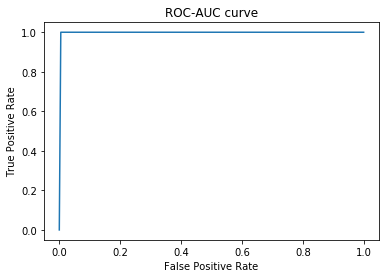

In [10]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve')

## Опробуем модель на отрывках из других текстов

In [11]:
import os
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [12]:
stop_words = set(stopwords.words("russian"))
stemmer = SnowballStemmer("russian")

def prepare_data(data):
    # делим на слова
    s = word_tokenize(data)
    # приводим к нижнему регистру, убираем пунктуацию
    s = [w.lower().translate(str.maketrans('', '', string.punctuation)) for w in s]
    # фильтруем слова не из алфавита
    s = [w for w in s if w.isalpha()]
    # преобразуем в коренные слова
    s = [stemmer.stem(w) for w in s]
    s = " ".join(s)
    
    s = tfidf.transform([s])
    return s

##### Гегель Георг Вильгельм Фридрих. Философия права
Ни в какой другой науке не чувствуется столь сильно потребность начинать с самой сути дела, без предварительных размышлений, как в науке логики. В каждой другой науке рассматриваемый ею предмет и научный метод различаются между собой; равным образом и содержание [этих наук] не начинает абсолютно с самого начала, а зависит от других понятий и связано с окружающим его иным материалом. Вот почему за этими науками признается право говорить лишь при помощи лемм о почве, на которой они стоят, и о ее связи, равно как и о методе, прямо применять предполагаемые известными и принятыми формы дефиниций и т. п. и пользоваться для установления своих всеобщих понятий и основных определений обычным способом рассуждения. Логика же, напротив, не может брать в качестве предпосылки ни одной из этих форм рефлексии или правил и законов мышления, ибо сами они составляют часть ее содержания и сначала должны получить свое обоснование внутри нее. Но в ее содержание входит не только указание научного метода, но и вообще само понятие науки, причем это понятие составляет ее конечный результат: она поэтому не может заранее сказать, что она такое, лишь все ее изложение порождает это знание о ней самой как ее итог (Letztes) и завершение. И точно так же ее предмет, мышление или, говоря определеннее, мышление, постигающее в понятиях, рассматривается по существу внутри нее; понятие этого мышления образуется в ходе ее развертывания и, стало быть, не может быть предпослано. То, что мы предпосылаем здесь в этом введении, не имеет поэтому своей целью обосновать, скажем, понятие логики или дать наперед научное обоснование ее содержания и метода, а имеет своей целью с помощью некоторых разъяснений и размышлений в рассуждающем и историческом духе растолковать представлению ту точку зрения, с которой следует рассматривать эту науку. 

In [13]:
s = "Ни в какой другой науке не чувствуется столь сильно потребность начинать с самой сути дела, без предварительных размышлений, как в науке логики. В каждой другой науке рассматриваемый ею предмет и научный метод различаются между собой; равным образом и содержание [этих наук] не начинает абсолютно с самого начала, а зависит от других понятий и связано с окружающим его иным материалом. Вот почему за этими науками признается право говорить лишь при помощи лемм о почве, на которой они стоят, и о ее связи, равно как и о методе, прямо применять предполагаемые известными и принятыми формы дефиниций и т. п. и пользоваться для установления своих всеобщих понятий и основных определений обычным способом рассуждения. Логика же, напротив, не может брать в качестве предпосылки ни одной из этих форм рефлексии или правил и законов мышления, ибо сами они составляют часть ее содержания и сначала должны получить свое обоснование внутри нее. Но в ее содержание входит не только указание научного метода, но и вообще само понятие науки, причем это понятие составляет ее конечный результат: она поэтому не может заранее сказать, что она такое, лишь все ее изложение порождает это знание о ней самой как ее итог (Letztes) и завершение. И точно так же ее предмет, мышление или, говоря определеннее, мышление, постигающее в понятиях, рассматривается по существу внутри нее; понятие этого мышления образуется в ходе ее развертывания и, стало быть, не может быть предпослано. То, что мы предпосылаем здесь в этом введении, не имеет поэтому своей целью обосновать, скажем, понятие логики или дать наперед научное обоснование ее содержания и метода, а имеет своей целью с помощью некоторых разъяснений и размышлений в рассуждающем и историческом духе растолковать представлению ту точку зрения, с которой следует рассматривать эту науку. "
print("Автор текста: {}".format(predict_class[LR.predict(prepare_data(s))[0]]))

Автор текста: Гегель


###### Гоголь Николай. Страшная месть
        Бiжить возок кривавенький;
        У тiм возку козак лежить,
        Пострiляний, порубаний.
        В правiй ручцi дротик держить,
        З того дроту крiвця бежить;
        Бiжить река кривавая.
        Над рiчкою явор стоiть,
        Над явором ворон кряче.
        За козаком мати плаче.
        Не плачь, мати, не журися!
        Бо вже твiй сын оженився,
        Та взяв женку паняночку,
        В чистом полi земляночку,
        I без дверець, без оконець.
        Та вже пiснi вийшов конець.
        Танцiвала рыба з раком…
        А хто мене не полюбить, трясця его матерь!

In [14]:
s = "Бiжить возок кривавенький; У тiм возку козак лежить, Пострiляний, порубаний. В правiй ручцi дротик держить, З того дроту крiвця бежить; Бiжить река кривавая. Над рiчкою явор стоiть, Над явором ворон кряче. За козаком мати плаче. Не плачь, мати, не журися! Бо вже твiй сын оженився, Та взяв женку паняночку, В чистом полi земляночку, I без дверець, без оконець. Та вже пiснi вийшов конець. Танцiвала рыба з раком… А хто мене не полюбить, трясця его матерь!"
print("Автор текста: {}".format(predict_class[LR.predict(prepare_data(s))[0]]))

Автор текста: Гоголь
